In [4]:
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

class Elevator:
  
    def __init__(self, n_floors,pickup_destinations, max_passengers):
        '''
        Constructor - takes the number of floors and maximum number of passengers as input,
        saves all the pressed buttons both inside and outside at any given time,
        keeps track of current floor and current passengers
        
        '''
        self.n_floors = n_floors #number of floors
        self.max_passengers = max_passengers #maximum number of passengers - capacity of elevator
        self.dropoff_destinations = np.zeros(n_floors) # where people want to go 
        self.pickup_destinations = pickup_destinations # where people are (pressing buttons)
        self.passengers = [] #passengers currently inside the elevator
        self.current_floor = 0 #elevator starting point - always 0
        self.all_trip_times = [] #array with all the passenger trip times, starts empty
    
    def decide_floor_random(self):
        '''
        Elevator goes to a random floor.
        '''
        return np.random.randint(self.n_floors)
    
    def decide_floor_greedy(self):
        '''
        If there are passengers inside, then elevator goes to nearest destination.
        Otherwise, elevator goes to nearest floor which has passengers.
        '''
        if len(self.passengers) == 0: #elevator is currently empty:
          buttons_pressed = np.nonzero(self.pickup_destinations)[0] #check which buttons are pressed outside
        else: #elevator is not empty:
          buttons_pressed = np.nonzero(self.dropoff_destinations)[0] #check which buttons are pressed inside

        distances = np.abs(buttons_pressed - self.current_floor) #distance from current floor to all buttons pressed
        closest_floor = buttons_pressed[np.argmin(distances)] # closest floor to current - our new destination
        return closest_floor
        
    
    def decide_floor(self, strat):
        '''
        Elevator goes to floor based on strategy.
        '''
        if strat == "random":
          return self.decide_floor_random()
        if strat == "greedy":
          return self.decide_floor_greedy()
        
  
    def dropoff(self):
        '''
        Elevator drops off passengers at the current floor.
        Then, it resets the button for that floor inside,
        And keeps track of the total trip time for everyone who gets off.
        '''
        self.dropoff_destinations[self.current_floor] = 0 # resetting button inside elevator
        current_passengers = self.passengers.copy() #copy all the current passengers
        for p in current_passengers: 
          if p.destination == self.current_floor: #passenger wants to get off at current floor
            self.all_trip_times.append(p.trip_time) #append their trip time to the array
            self.passengers.remove(p) #remove passenger from elevator

    def pickup(self,passengers_on_floor):
        '''
        Elevator picks up passengers at the current floor, up to max capacity.
        The buttons for these passengers' destinations are turned on,
        Method returns everyone still on that floor so that building updates.
        '''
        while len(self.passengers) < self.max_passengers and len(passengers_on_floor) > 0: 
            #while elevator is not at maximum capacity and there are people on the floor wishing to get on:
          current_passenger = passengers_on_floor.pop() #take a person from the floor
          self.dropoff_destinations[current_passenger.destination] = 1 #turn on the button to their destination
          self.passengers.append(current_passenger) #put them in the elevator       
        if len(passengers_on_floor) == 0: #there are no more passengers on the floor
          self.pickup_destinations[self.current_floor] = 0 # resetting button outside 
        return passengers_on_floor #return remaining passengers on floor
    
  
    def visit_floor(self, floor, passengers_on_floor): 
        '''
        This method moves the elevator to the decided floor, 
        Then drops off and picks up passengers.
        '''
        self.current_floor = floor 
        self.dropoff()
        #keep track of all the passengers still on the floor:
        remaining_passengers_on_floor = self.pickup(passengers_on_floor) 
        return remaining_passengers_on_floor #return them to the building

class Building:
  
    def __init__(self, passengers_on_floors, n_floors, strat, max_passengers): 
        '''
        Constructor - takes as input the distribution of passengers on floors,
        the number of floors, and the elevator strategy and capacity.
        '''
        self.n_floors = n_floors #number of floors in the building
        self.passengers_on_floors = passengers_on_floors #gets the passengers distribution from SimControl
        self.pickup_destinations = np.zeros(n_floors) # where people are (pressing buttons)
        self.strat = strat #saves the chosen strategy (random or greedy)
        
        for i, floor in enumerate(passengers_on_floors): #for each floor:
          if len(floor) != 0: #if there are passengers:
            self.pickup_destinations[i] = 1  #press the button for the elevator on that floor
            
        self.my_elevator = Elevator(n_floors, self.pickup_destinations, max_passengers) #create the building elevator
        
    def run(self, debug): 
        '''
        Main simulation loops - terminates when all passengers reach destination.
        After each elevator trip, updates the total trip time of all passengers
        who have yet to reach their destination (inside or outside elevator)
        '''
        while True: #main loop - stops only when all passengers reach their destination
          if debug: #if debug mode is on, print current state
            print("building", self.passengers_on_floors)
            print("elevator", self.my_elevator.passengers)
          #if all the buttons are turned off, that means everyone reached their destination and we can stop:
          if sum(self.my_elevator.dropoff_destinations) == 0 and sum(self.my_elevator.pickup_destinations) == 0:
            if debug: print("done!")
            return np.array(self.my_elevator.all_trip_times) #after simulation ends, it returns the total trip times
            
          goto_floor = self.my_elevator.decide_floor(self.strat) # floor to go to 
          if debug:
            print('going to floor', goto_floor, "\n")
          
          current_trip_time = abs(self.my_elevator.current_floor - goto_floor) + 1 # + 1 for open / closing of door 
          
          for p in self.my_elevator.passengers: #for all the passengers inside
            p.trip_time += current_trip_time #add the time the current trip takes to their personal trip time
          for floor in self.passengers_on_floors: #for all the floors in the building
            for p in floor: #for each passenger on that floor
              p.trip_time += current_trip_time #add the time the current trip takes to their personal trip time
          remaining_passengers_on_floor = self.my_elevator.visit_floor(
                                          goto_floor, self.passengers_on_floors[goto_floor])
          self.passengers_on_floors[goto_floor] = remaining_passengers_on_floor # number of people on floor updated

class Passenger:
  
    def __init__(self, destination, origin):
        '''
        Constructor - takes as input origin and destination of passenger.
        '''
        self.origin = origin #the passenger's personal destination
        self.destination = destination #the passenger's personal destination, different than origin
        self.trip_time = 0 #trip time always starts at 0
        
    
    def __repr__(self):
        '''
        Representation of passenger object for debugging purposes.
        Irrelevant for simulation logic.
        '''
        return f'from {self.origin} to {self.destination}' 
 
class SimulationControl:
  
    def __init__(self, n_floors, n_passengers, strat, max_passengers=3, debug = False):
        '''
        Takes as input number of floors and passengers, strategy,
        maximum capacity of elevator, and optionally debug mode.
        '''
        self.n_floors = n_floors #number of floors in building
        self.n_passengers = n_passengers #number of passengers (people) in building
        self.passengers_on_floors = [[] for i in range(n_floors)] # initially building is empty
        self.initialize_passengers() #fills building with passengers randomly
        self.my_building = Building(self.passengers_on_floors, n_floors, strat, max_passengers) #creates building
        self.debug = debug #keeps track of debug flag
        
    def start_simulation(self):
      '''
      Starts the simulation by runnig building's "run" method.
      '''
      return self.my_building.run(self.debug) #runs the main loop in the Building class
    
        
    def initialize_passengers(self):
        '''
        Initializes passengers to have random different origin and destination.
        '''
        # for each passenger, generates a random origin floor and a different random destination floor
        floors = np.arange(self.n_floors) # all possible floors, 0 to n_floors - 1 
        for i in range(self.n_passengers): #for each passenger
            #without replacement guarantees a different destination
            origin, destination = np.random.choice(floors, 2, replace=False) 
            passenger = Passenger(destination, origin) #creates a passenger with above origin and destination
            self.passengers_on_floors[origin].append(passenger) #puts the passenger on the correct floor

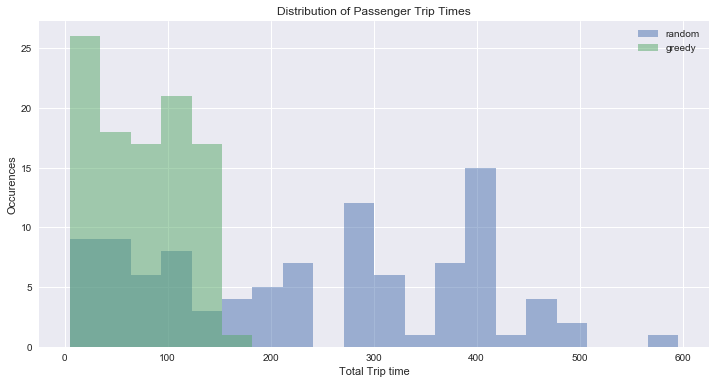

Random Strategy Min: 10
Greedy Strategy Min: 5
Random Strategy Max: 596
Greedy Strategy Max: 161
Random Strategy Mean: 239.52
Greedy Strategy Mean: 74.83


In [5]:
import matplotlib.pyplot as plt


def make_plot(seed,floors,passengers,max_passengers):
  '''
  Takes as input a random seed, number of floors and passengers,
  and elevator capacity. Produces a histogram with frequency of trip times,
  as well as summary statistics for each strategy.
  '''
  np.random.seed(seed) #fixed seed - important in order to compare the two strategies!
  r_sim = SimulationControl(floors,passengers,"random",max_passengers).start_simulation() #random strategy results
  g_sim = SimulationControl(floors,passengers,"greedy",max_passengers).start_simulation() #greedy strategy results
  bins = np.histogram(np.hstack((r_sim, g_sim)), bins=20)[1] #same 20 bins for both strategies
  plt.figure(figsize=(12,6))
  plt.hist(r_sim, bins=bins, label="random", alpha=0.5) #plot histogram of waiting times
  #plt.show() #enable this for two separate histograms
  plt.hist(g_sim, bins=bins, label="greedy", alpha=0.5) #plot histogram of waiting times
  plt.legend() #adds legend with strategies
  plt.title("Distribution of Passenger Trip Times")
  plt.xlabel("Total Trip time")
  plt.ylabel("Occurences")
  plt.show()
  
  print ("Random Strategy Min:", r_sim.min())
  print ("Greedy Strategy Min:", g_sim.min())
  print ("Random Strategy Max:", r_sim.max())
  print ("Greedy Strategy Max:", g_sim.max())
  print ("Random Strategy Mean:", r_sim.mean())
  print ("Greedy Strategy Mean:", g_sim.mean())
  

make_plot(seed=42, floors=10, passengers=100, max_passengers=10)

In [17]:
#demonstration of debugging mode
SimulationControl(n_floors=5, n_passengers=10, strat='greedy', max_passengers=5, debug=True).start_simulation()

building [[from 0 to 3], [from 1 to 4], [from 2 to 4, from 2 to 0], [from 3 to 2, from 3 to 4, from 3 to 0, from 3 to 0], [from 4 to 2, from 4 to 2]]
elevator []
going to floor 0 

building [[], [from 1 to 4], [from 2 to 4, from 2 to 0], [from 3 to 2, from 3 to 4, from 3 to 0, from 3 to 0], [from 4 to 2, from 4 to 2]]
elevator [from 0 to 3]
going to floor 3 

building [[], [from 1 to 4], [from 2 to 4, from 2 to 0], [], [from 4 to 2, from 4 to 2]]
elevator [from 3 to 0, from 3 to 0, from 3 to 4, from 3 to 2]
going to floor 2 

building [[], [from 1 to 4], [], [], [from 4 to 2, from 4 to 2]]
elevator [from 3 to 0, from 3 to 0, from 3 to 4, from 2 to 0, from 2 to 4]
going to floor 0 

building [[], [from 1 to 4], [], [], [from 4 to 2, from 4 to 2]]
elevator [from 3 to 4, from 2 to 4]
going to floor 4 

building [[], [from 1 to 4], [], [], []]
elevator [from 4 to 2, from 4 to 2]
going to floor 2 

building [[], [from 1 to 4], [], [], []]
elevator []
going to floor 1 

building [[], [], [],

array([ 5,  7, 10, 10, 10, 15, 15, 18, 18, 24])